引力波数据分析程序
选择要分析的事件:
1. GW170817 (中子星合并)
2. GW150914 (黑洞合并)
开始分析引力波事件: GW170817
从GWOSC获取应变数据...
成功获取 GW170817 数据: 327680 个数据点
进行频谱分析...


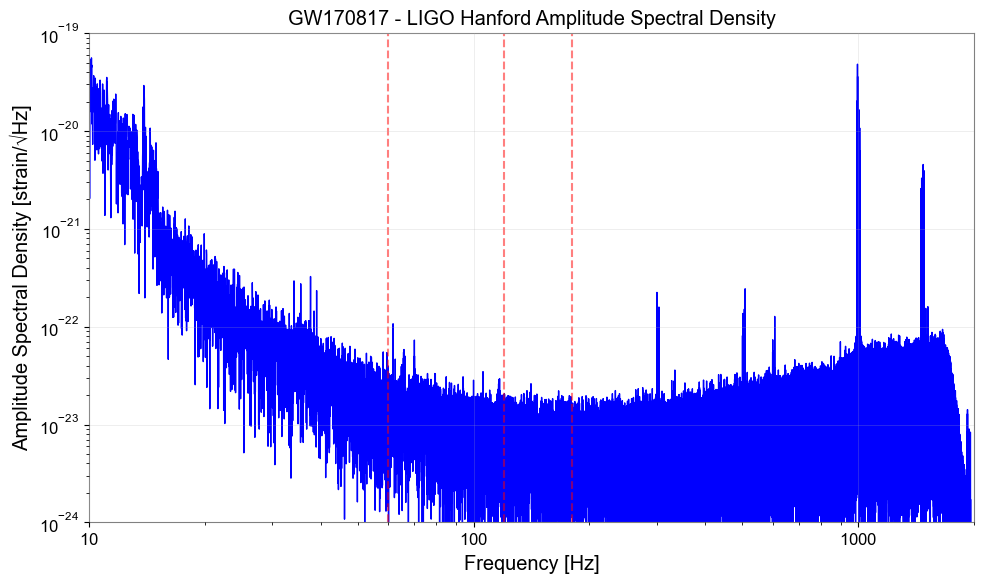

设计滤波器...
滤波器应用完成
绘制滤波效果...
比较滤波前后频谱...


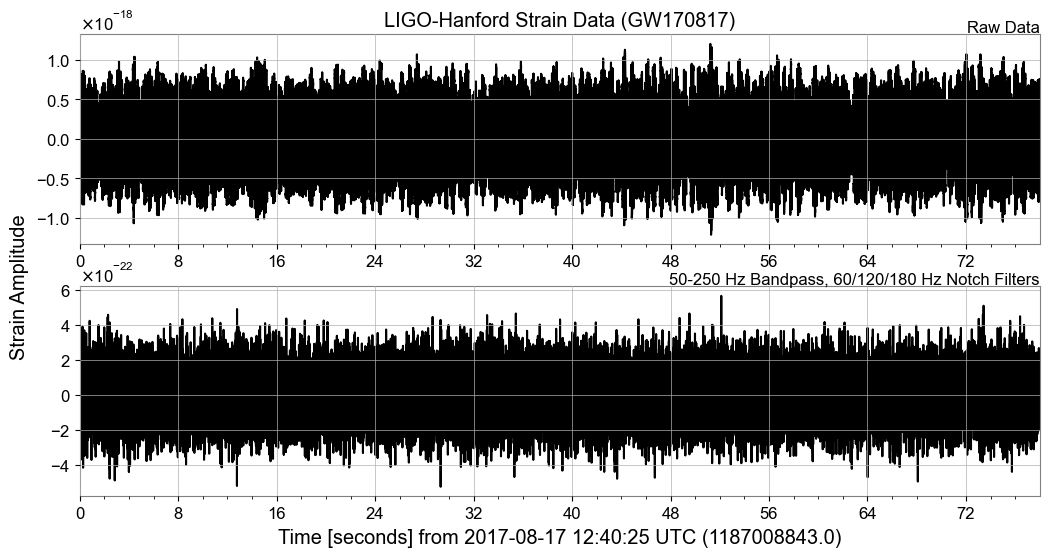

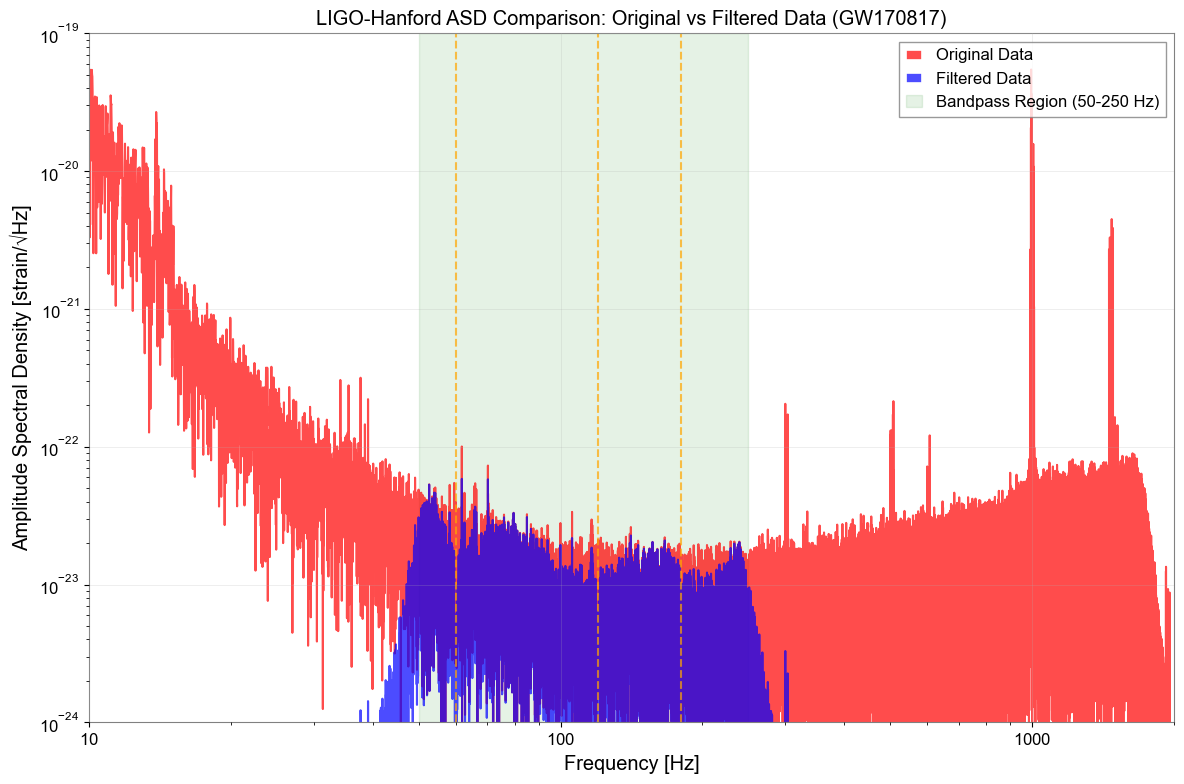

分析滤波后数据细节...
获取利文斯顿观测站数据进行比较...
进行Q变换时频分析...


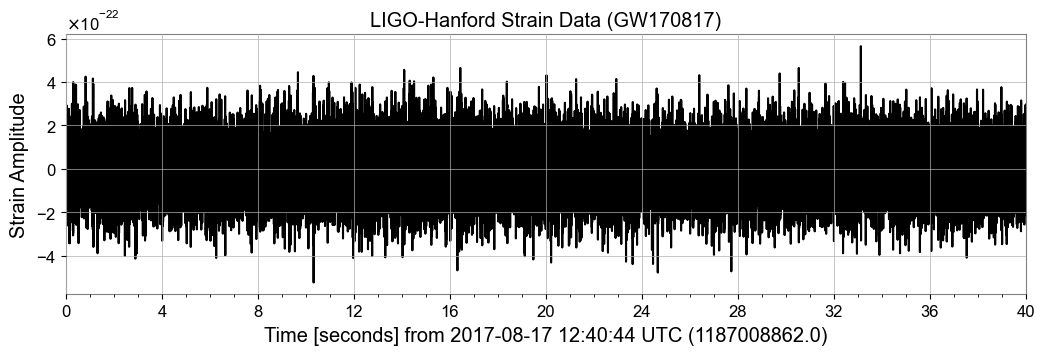

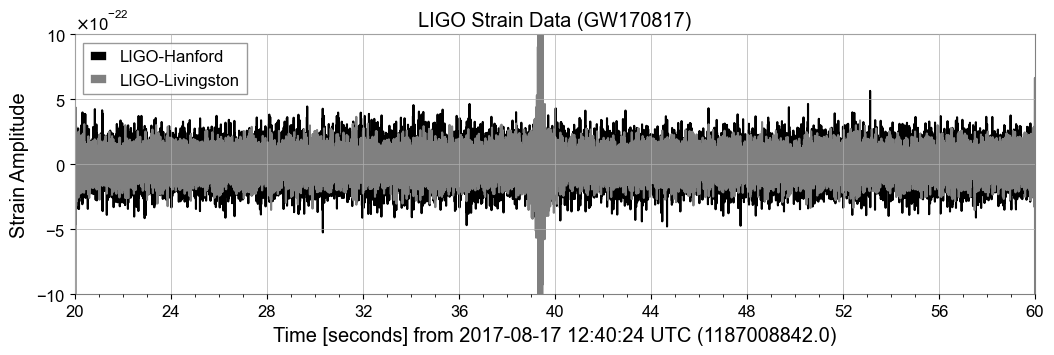

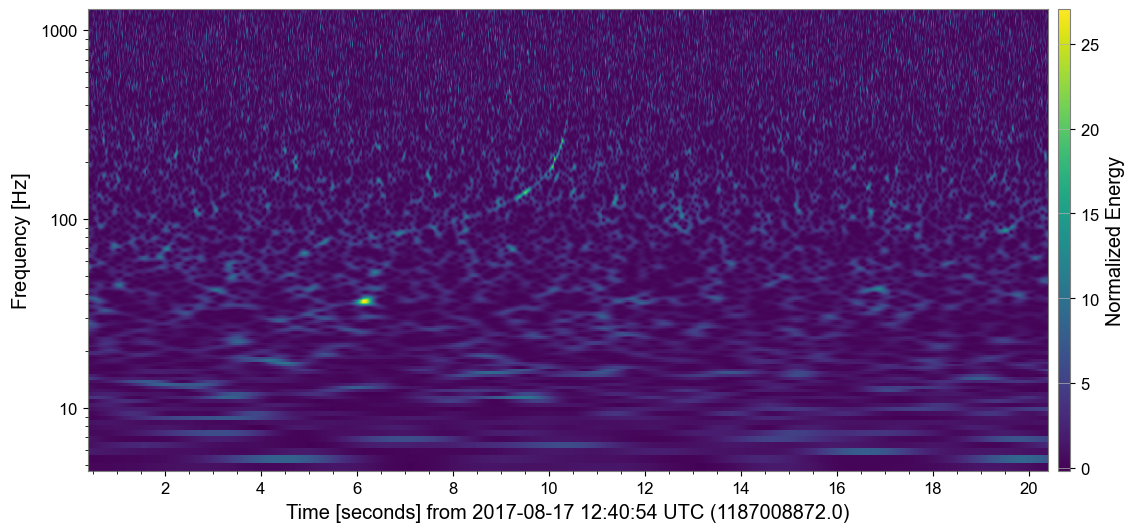

生成引力波音频文件...
音频采样率 fs = 4096
音频文件已保存: audio/gravitational_wave_GW170817.wav
分析完成！


In [4]:
#!/usr/bin/env python3
"""
Gravitational Wave Data Analysis Main Program
Based on LIGO data from GW150914 and GW170817 events
"""

import numpy as np
import matplotlib.pyplot as plt
from scipy.io.wavfile import write
import warnings
warnings.filterwarnings('ignore')

# ==================== Import necessary libraries ====================
try:
    from gwpy.timeseries import TimeSeries
    from gwpy.signal import filter_design
    from gwpy.plot import Plot
except ImportError:
    print("Error: Please install GWPy library first: pip install gwpy")
    exit(1)


def analyze_gravitational_wave(event_type=2, generate_audio=True):
    """
    Main analysis function
    
    Parameters:
    event_type: 1=GW170817, 2=GW150914
    generate_audio: whether to generate audio files
    """
    
    print(f"开始分析引力波事件: {'GW170817' if event_type == 1 else 'GW150914'}")
    print("=" * 50)
    
    # ==================== 数据获取 ====================
    print("从GWOSC获取应变数据...")
    
    if event_type == 1:
        # GW170817 - 中子星合并事件
        t0 = 1187008882.4
        start_time = 1187008842
        end_time = 1187008922
        event_name = "GW170817"
    else:
        # GW150914 - 第一个黑洞合并事件  
        t0 = 1126259462.4
        start_time = 1126259446
        end_time = 1126259478
        event_name = "GW150914"
    
    # 获取汉福德观测站数据
    hdata = TimeSeries.fetch_open_data('H1', start_time, end_time)
    print(f"成功获取 {event_name} 数据: {len(hdata)} 个数据点")
    
    # ==================== 频谱分析 ====================
    print("进行频谱分析...")
    
    plt.figure(figsize=[10, 6])
    asd = hdata.asd()
    plt.plot(asd.frequencies, asd, color='blue', linewidth=1)
    plt.xlim(10, 2000)
    plt.ylim(1e-24, 1e-19)
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel('Frequency [Hz]')
    plt.ylabel('Amplitude Spectral Density [strain/√Hz]')
    plt.title(f'{event_name} - LIGO Hanford Amplitude Spectral Density')
    plt.grid(True, alpha=0.3)
    
    # 标记电源线干扰
    ymin, ymax = 1e-24, 1e-19
    for freq in [60, 120, 180]:
        plt.axvline(freq, linestyle="--", color="red", alpha=0.5)
    
    plt.tight_layout()
    plt.savefig(f'results/plots/{event_name}_ASD.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # ==================== 滤波器设计 ====================
    print("设计滤波器...")
    
    # 设计带通滤波器（50-250Hz）
    bp = filter_design.bandpass(50, 250, hdata.sample_rate)
    
    # 设计陷波滤波器消除电源线干扰
    notches = [filter_design.notch(line, hdata.sample_rate) for line in (60, 120, 180)]
    
    # 合并滤波器
    zpk = filter_design.concatenate_zpks(bp, *notches)
    
    # 应用滤波器
    hfilt = hdata.filter(zpk, filtfilt=True)
    
    # 裁剪数据边界以避免边缘效应
    hdata = hdata.crop(*hdata.span.contract(1))
    hfilt = hfilt.crop(*hfilt.span.contract(1))
    
    print("滤波器应用完成")
    
    # ==================== 滤波效果可视化 ====================
    print("绘制滤波效果...")
    
    plot = Plot(
        hdata,
        hfilt, 
        figsize=[12, 6],
        separate=True,
        sharex=True,
        color='black'
    )
    ax1, ax2 = plot.axes
    
    ax1.set_title(f'LIGO-Hanford Strain Data ({event_name})')
    ax1.text(1.0, 1.01, 'Raw Data', transform=ax1.transAxes, ha='right')
    ax1.set_ylabel('Strain Amplitude', y=-0.2)
    
    ax2.set_ylabel('')
    ax2.text(1.0, 1.01, '50-250 Hz Bandpass, 60/120/180 Hz Notch Filters',
             transform=ax2.transAxes, ha='right')
    
    plot.savefig(f'results/plots/{event_name}_filter_comparison.png', dpi=300)
    plot.show()
    
    # ==================== 滤波前后ASD对比 ====================
    print("比较滤波前后频谱...")
    
    plt.figure(figsize=[12, 8])
    
    asd_original = hdata.asd()
    plt.plot(asd_original.frequencies, asd_original,
             label='Original Data', color='red', alpha=0.7, linewidth=1.5)
    
    asd_filtered = hfilt.asd()
    plt.plot(asd_filtered.frequencies, asd_filtered,
             label='Filtered Data', color='blue', alpha=0.7, linewidth=1.5)
    
    plt.xlim(10, 2000)
    plt.ylim(1e-24, 1e-19)
    plt.xlabel('Frequency [Hz]')
    plt.ylabel('Amplitude Spectral Density [strain/√Hz]')
    
    # 标记滤波器范围
    plt.axvspan(50, 250, alpha=0.1, color='green', label='Bandpass Region (50-250 Hz)')
    
    for freq in [60, 120, 180]:
        plt.axvline(freq, linestyle="--", color="orange", alpha=0.7)
    
    plt.legend(loc='upper right')
    plt.title(f'LIGO-Hanford ASD Comparison: Original vs Filtered Data ({event_name})')
    plt.grid(True, alpha=0.3)
    plt.xscale('log')
    plt.yscale('log')
    plt.tight_layout()
    plt.savefig(f'results/plots/{event_name}_ASD_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # ==================== 滤波后数据细节分析 ====================
    print("分析滤波后数据细节...")
    
    plot = hfilt.plot(color='black')
    ax = plot.gca()
    ax.set_ylabel('Strain Amplitude')
    
    if event_type == 1:
        ax.set_title('LIGO-Hanford Strain Data (GW170817)')
        ax.set_xlim(1187008862, 1187008902)
        ax.set_xscale('seconds', epoch=1187008862)
    else:
        ax.set_title('LIGO-Hanford Strain Data (GW150914)')
        ax.set_xlim(1126259462, 1126259462.6)
        ax.set_xscale('seconds', epoch=1126259462)
    
    plot.savefig(f'results/plots/{event_name}_filtered_strain.png', dpi=300)


    plot.show()
    
    # 提取绘图数据用于后续处理
    x_val = plt.gca().lines[0].get_xdata()
    y_val = plt.gca().lines[0].get_ydata()
    
    # ==================== 双观测站数据对比 ====================
    print("获取利文斯顿观测站数据进行比较...")
    
    if event_type == 1:
        ldata = TimeSeries.fetch_open_data('L1', 1187008862, 1187008902)
    else:
        ldata = TimeSeries.fetch_open_data('L1', 1126259446, 1126259478)
    
    # 应用相同的滤波器
    lfilt = ldata.filter(zpk, filtfilt=True)
    
    # 对L1数据进行时间偏移和相位调整
    lfilt.shift('6.9ms')
    lfilt *= -1
    
    # 绘制两个观测站数据的对比图
    plot = Plot(figsize=[12, 4])
    ax = plot.gca()
    ax.plot(hfilt, label='LIGO-Hanford', color='black')
    ax.plot(lfilt, label='LIGO-Livingston', color='gray')
    
    if event_type == 1:
        ax.set_title('LIGO Strain Data (GW170817)')
        ax.set_xlim(1187008862, 1187008902)
        ax.set_xscale('seconds', epoch=1187008842)
    else:
        ax.set_title('LIGO Strain Data (GW150914)')
        ax.set_xlim(1126259462, 1126259462.6)
        ax.set_xscale('seconds', epoch=1126259462)
    
    ax.set_ylabel('Strain Amplitude')
    ax.set_ylim(-1e-21, 1e-21)
    ax.legend()
    plot.savefig(f'results/comparisons/{event_name}_detector_comparison.png', dpi=300)
    plot.show()
    
    # ==================== Q变换时频分析 ====================
    print("进行Q变换时频分析...")
    
    if event_type == 1:
        dt_0 = 10
        dt_1 = 10
    else:
        dt_0 = 0.2
        dt_1 = 0.1
        
    hq = hfilt.q_transform(outseg=(t0-dt_0, t0+dt_1))
    fig4 = hq.plot()
    ax = fig4.gca()
    fig4.colorbar(label="Normalized Energy")
    ax.grid(False)
    ax.set_yscale('log')
    plt.savefig(f'results/plots/{event_name}_q_transform.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # ==================== 音频生成 ====================
    if generate_audio:
        print("生成引力波音频文件...")
        
        amplitude = np.iinfo(np.int16).max
        
        # 提取事件前后1.5秒的数据用于生成音频
        ind = np.where((x_val < (t0+1.5)) & (x_val > (t0-1.5)))
        y = y_val[ind]
        
        # 信号归一化处理
        y = y / np.max(y)
        
        # 计算实际采样率并生成WAV文件
        fs = int(1 / np.median(np.diff(np.array(x_val[ind] - t0))))
        print(f"音频采样率 fs = {fs}")
        
        filename = f"audio/gravitational_wave_{event_name}.wav"
        write(filename, fs, (np.array(y) * amplitude).astype(np.int16))
        print(f"音频文件已保存: {filename}")
    
    print("=" * 50)
    print("分析完成！")
    return hdata, hfilt


if __name__ == "__main__":
    # 示例用法
    print("引力波数据分析程序")
    print("选择要分析的事件:")
    print("1. GW170817 (中子星合并)")
    print("2. GW150914 (黑洞合并)")
    
    try:
        choice = int(input("请输入选择 (1 或 2, 默认2): ") or "2")
        audio_choice = input("是否生成音频文件? (y/n, 默认y): ").lower() or "y"
        
        generate_audio = audio_choice in ['y', 'yes', '是']
        
        # 运行分析
        original_data, filtered_data = analyze_gravitational_wave(
            event_type=choice,
            generate_audio=generate_audio
        )
        
    except KeyboardInterrupt:
        print("\n用户中断程序")
    except Exception as e:
        print(f"发生错误: {e}")